# Learning Curves


We aim to find out how strong every model is affected by additional training examples. We base our insights on a similar approach to: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

__Hypothesis:__ We would expect to see a stronger overall performance in F1-Scores of Transformers based models, but also stronger increases in performance (F1-Scores) for every sample added. Samples are added by percentage of overall training data.

We perform a 0.33 split between training and testdata

## Load Results

In [1]:
import os
from tiltify.config import Path
from glob import glob
import json

iwpe_dir = os.path.join(Path.root_path, "experiments/IWPE/training")
results_per_model = {}
for results_path in glob(os.path.join(iwpe_dir, "*/results.json")):
    model_name = results_path.split("/")[-2]
    with open(results_path, "r") as f:
        results = json.load(f)
    results_per_model[model_name] = results


Environment Variables not found. Entering Test Mode!


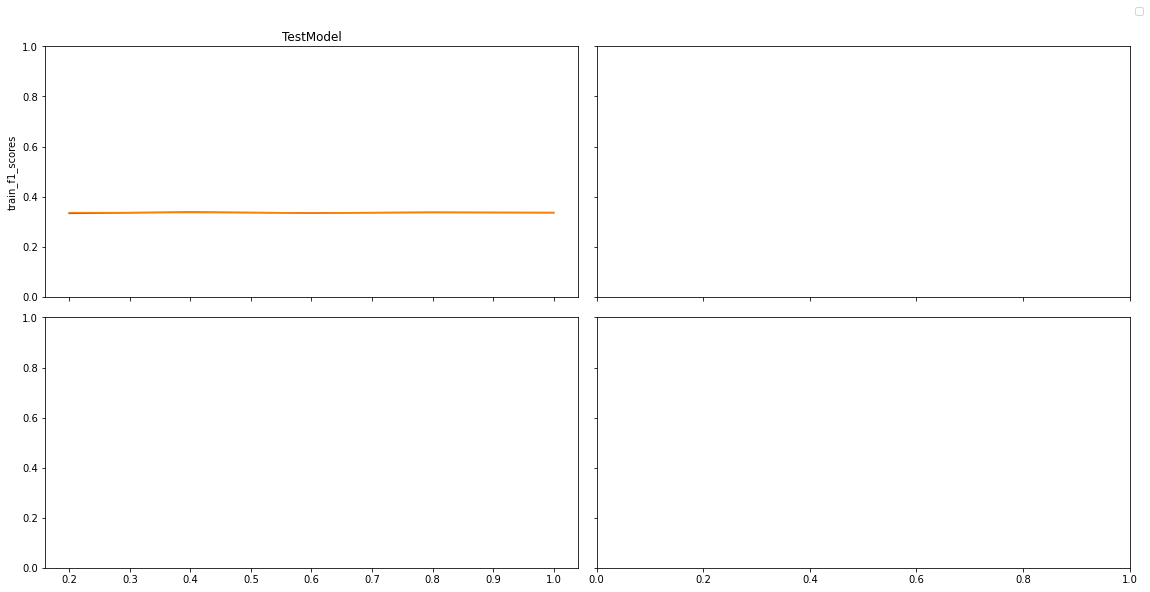

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import create_learning_df



fig, ax = plt.subplots(2, 2, sharex="col", sharey="row")
fig.set_size_inches(16, 8)

k = 0
i = 0
j = 0
for model_name, results in results_per_model.items():
    if k >= 2:
        i = 1
    else: 
        i = 0
    if k in [1, 3]:
        j = 1
    else:
        j = 0

    learning_df = create_learning_df(results, type_of_results="classify_metrics")
    plot_idx = learning_df["train_size"]
    ax[i, j].set_ylim([0, 1])
    sns.lineplot(data=learning_df, x=plot_idx, y="train_f1_scores", ax=ax[i,j])
    sns.lineplot(data=learning_df, x=plot_idx, y="test_f1_scores", ax=ax[i,j])
    ax[i, j].fill_between(plot_idx, learning_df["min_train_f1_scores"], learning_df["max_train_f1_scores"], alpha=.2)
    ax[i, j].fill_between(plot_idx, learning_df["min_test_f1_scores"], learning_df["max_test_f1_scores"], alpha=.2)
    ax[i, j].set_title(model_name)
    k += 1

lines_labels = [single_ax.get_legend_handles_labels() for single_ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, sorted(set(labels)), loc="lower right", ncol=2, bbox_to_anchor=(1,1), bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
